**Name: Ong Si Ying Rean**  
**Matriculation Number: A0257730A**  
**Github Repository: https://github.com/reanosy26/DSA4262.git**

# 1. Configurations

In [1]:
# --- Standard Library & OS ---
import os
import re
import string
import random

# --- Data Processing & Math ---
import pandas as pd
import numpy as np
from scipy import stats

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import shap

# --- Scikit-Learn: Preprocessing & Pipeline ---
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Scikit-Learn: Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- Scikit-Learn: Model Selection & Evaluation ---
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    precision_recall_curve
)

sns.set_context("talk")

dreaddit_train = pd.read_csv('./data/dreaddit-train.csv')
dreaddit_test = pd.read_csv('./data/dreaddit-test.csv')

SEED = 4262
random.seed(SEED)
np.random.seed(SEED)

c:\Users\User\Desktop\DSA4262\DSA4262\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Exploratory Data Analysis

Before we start building the predictive models, it is basic practice to ensure the data is ready for modelling. We will also explore the data to find meaningful patterns that could be taken into account when building out models.  

This EDA will cover on the:
1. Missing Values
2. Class Imbalances in labels by global, and by subreddits
3. Confidence metrics
4. Feature Importance

## 2.1 Missing Values

In [2]:
# Check for missing values in the training dataset
missing_data_train = dreaddit_train.isnull().sum().sum()
print(f'Total Missing Values in training dataset: {missing_data_train}')

# Check for duplicates in the training dataset
duplicate_data_train = dreaddit_train.duplicated().sum()
print(f"Total Number of Duplicates in training dataset: {duplicate_data_train}")

# Check for missing values in the test dataset
missing_data_test = dreaddit_test.isnull().sum().sum()
print(f'\nTotal Missing Values in test dataset: {missing_data_test}')

# Check for duplicates in the test dataset
duplicate_data_test = dreaddit_test.duplicated().sum()
print(f"Total Number of Duplicates in test dataset: {duplicate_data_test}")

Total Missing Values in training dataset: 0
Total Number of Duplicates in training dataset: 0

Total Missing Values in test dataset: 0
Total Number of Duplicates in test dataset: 0


There is no missing values, hence we will not need to utilise any missing value imputation techniques.

## 2.2. Class Imbalances (Train and Test Dataset)

Size of training dataset: (2838, 116)


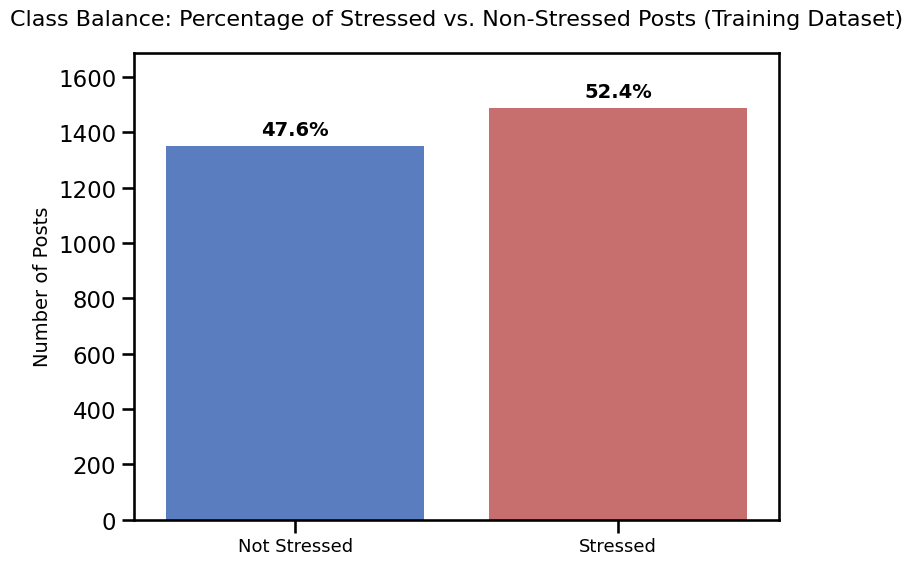

In [3]:
print(f'Size of training dataset: {dreaddit_train.shape}')

custom_colors = {1: "#d65f5f", 0: "#4878d0"}

# Create the plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=dreaddit_train, x='label', hue='label', palette=custom_colors, legend=False)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Not Stressed', 'Stressed'], fontsize=13)

# Calculate the total for percentage
total = len(dreaddit_train)

# Add percentages on top of bars
for p in ax.patches:
    # Calculate percentage
    percentage = f'{100 * p.get_height() / total:.1f}%'
    
    # Get coordinates
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    
    # Add text
    ax.annotate(percentage, 
                (x, y), 
                ha='center', 
                va='bottom', 
                fontsize=14, 
                fontweight='bold',
                xytext=(0, 5), 
                textcoords='offset points')

# Formatting
plt.title("Class Balance: Percentage of Stressed vs. Non-Stressed Posts (Training Dataset)", fontsize=16, pad=20)
plt.xlabel("")
plt.ylabel("Number of Posts", fontsize=14)
plt.ylim(0, dreaddit_train['label'].value_counts().max() + 200)

plt.tight_layout()

The train dataset has 2838 posts, with 52.4% being labelled as stressed (1) posts, and 47.6% being labelled as not stressed posts (0). This dataset is relatively balanced, and would less likely cause any biasness in our model later on.

Size of test dataset: (715, 116)


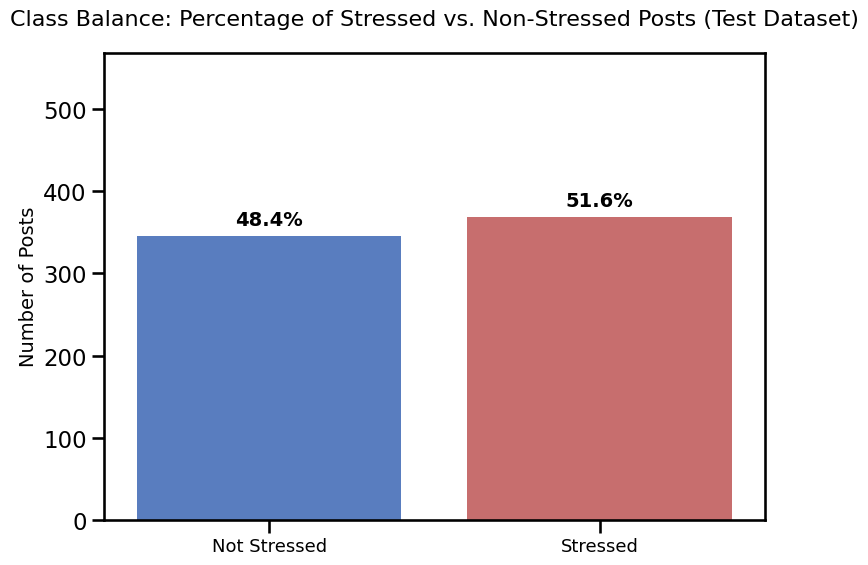

In [4]:
print(f'Size of test dataset: {dreaddit_test.shape}')

# Create the plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=dreaddit_test, x='label', hue='label', palette=custom_colors, legend=False)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Not Stressed', 'Stressed'], fontsize=13)

# Calculate the total for percentage
total = len(dreaddit_test)

# Add percentages on top of bars
for p in ax.patches:
    # Calculate percentage
    percentage = f'{100 * p.get_height() / total:.1f}%'
    
    # Get coordinates
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    
    # Add text
    ax.annotate(percentage, 
                (x, y), 
                ha='center', 
                va='bottom', 
                fontsize=14, 
                fontweight='bold',
                xytext=(0, 5), 
                textcoords='offset points')

# Formatting
plt.title("Class Balance: Percentage of Stressed vs. Non-Stressed Posts (Test Dataset)", fontsize=16, pad=20)
plt.xlabel("")
plt.ylabel("Number of Posts", fontsize=14)
plt.ylim(0, dreaddit_test['label'].value_counts().max() + 200)

plt.tight_layout()

Our test dataset has 715 posts in total, with again relatively balanced numbers for both Not Stressed and Stressed posts. We need not perform any class imbalance handling techniques.

## 2.3. Distribution of Train Dataset by Subreddits


As there are posts coming from 10 different subreddits, it will be good to look at their distributions. This is because subreddit imbalance could potentially affect the reliability of the predictive model, leading it to overfit to community-specific patterns rather than learning generalizable indicators of stress.

### 2.3.1 Number of Posts by Subredddit

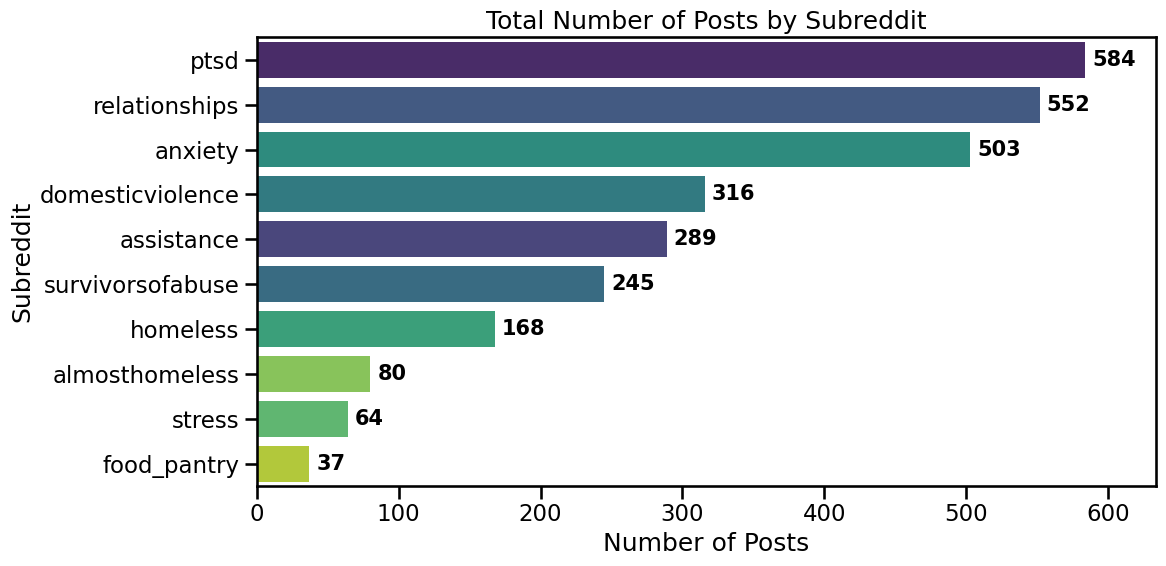

In [5]:
# plot the distribution of the total number of posts per subreddit 
subreddit_order = dreaddit_train['subreddit'].value_counts().index
total = len(subreddit_order)

plt.figure(figsize=(12,6))
ax = sns.countplot(data=dreaddit_train, 
                   y='subreddit', 
                   order=subreddit_order, 
                   hue='subreddit', 
                   palette='viridis')

for p in ax.patches: 
    width = p.get_width()
    if width > 0:
        y_center = p.get_y() + p.get_height()/2

        sub_index = int(round(y_center))
        sub_name = subreddit_order[sub_index]

        ax.annotate(round(width), 
                    (width, y_center),
                    ha='left',
                    va='center', 
                    fontsize=15,
                    fontweight='bold',
                    xytext=(5,0),
                    textcoords='offset points')
        
plt.title("Total Number of Posts by Subreddit")
plt.xlabel('Number of Posts')
plt.ylabel('Subreddit')

plt.xlim(0, max(dreaddit_train['subreddit'].value_counts()) + 50)

plt.tight_layout()
plt.show()

The chart shows that the dataset is unevenly distributed across the 10 subreddits:
- **High-volume subreddits:** ptsd (584 posts), relationships (552), and anxiety (503) dominate the dataset, contributing a large share of the total posts.
- **Moderate-volume subreddits:** domesticviolence (316), assistance (289), and survivorsofabuse (245) provide a mid-range contribution.
- **Low-volume subreddits:** homeless (168), almosthomeless (80), stress (64), and food_pantry (37) have relatively few posts.  
   
    




Implications for Predictive Modeling:
- **Class Imbalance Across Communities:** The model may learn patterns more strongly from high-volume subreddits (ptsd, relationships, anxiety) simply because they dominate the training data. This could bias predictions toward language and themes common in those communities.
- **Risk of Underrepresentation:** Subreddits with fewer posts (food_pantry, stress) may not provide enough examples for the model to learn reliable stress indicators. Predictions for these communities could be less accurate or unstable.
- **Generalization Challenge:** If subreddit identity is included as a feature, the imbalance could cause the model to rely heavily on subreddit membership rather than linguistic features. This risks poor generalization when applied to unseen or underrepresented communities.

### 2.3.2. Stress Rates by Subreddit



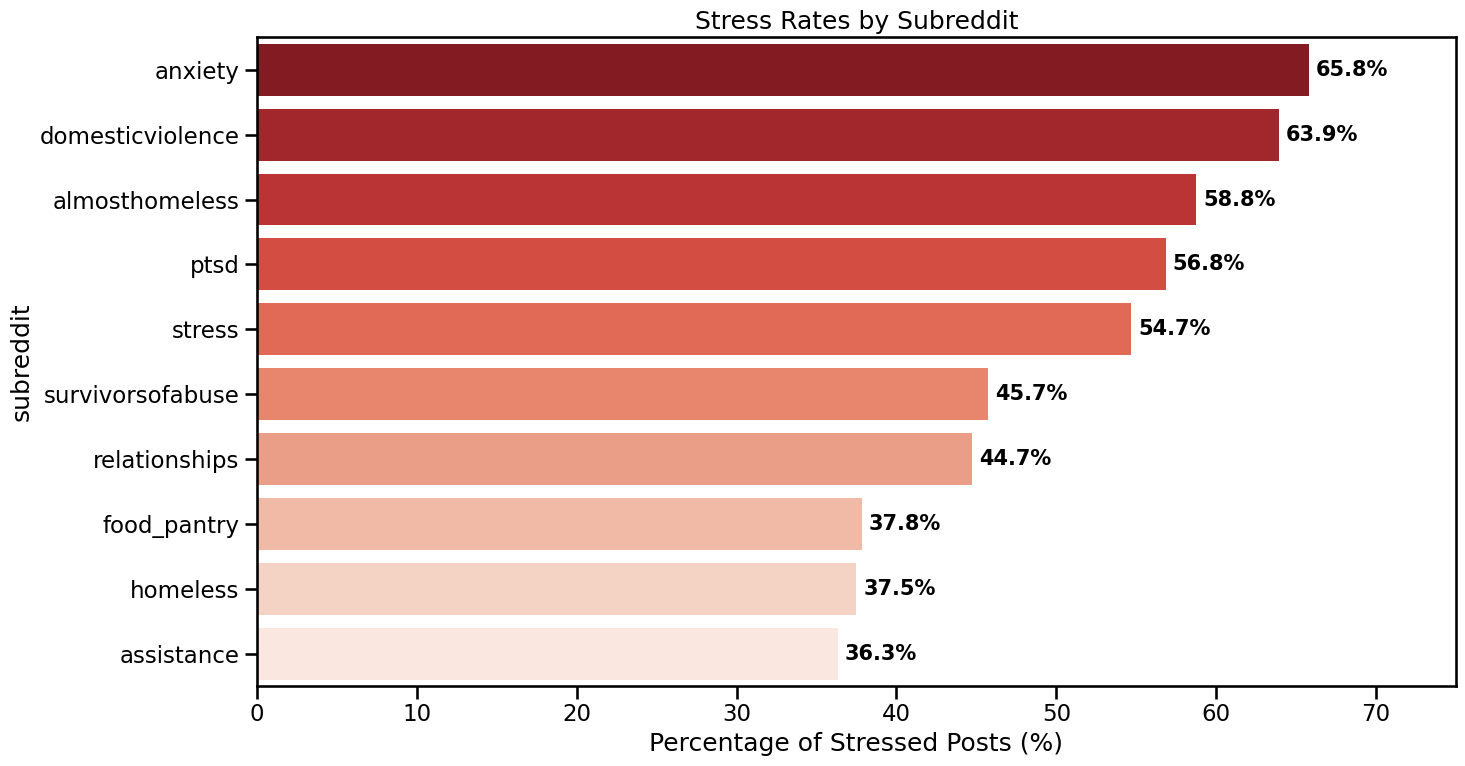

In [6]:
stress_rates = dreaddit_train.groupby('subreddit')['label'].mean().sort_values(ascending=False).reset_index()
stress_rates['stress_percentage'] = stress_rates['label'] * 100

plt.figure(figsize=(15, 8))
ax1 = sns.barplot(data=stress_rates, y='subreddit', x='stress_percentage', palette='Reds_r', hue='subreddit', legend=False)

for p in ax1.patches: 
    ax1.annotate(f'{p.get_width():.1f}%',
                (p.get_width(), p.get_y()+p.get_height()/2),
                ha='left',
                va='center', 
                fontsize=15,
                fontweight='bold',
                xytext=(5,0),
                textcoords='offset points'
                )
    
plt.title('Stress Rates by Subreddit')
plt.xlabel('Percentage of Stressed Posts (%)')
plt.xlim(0,75)
plt.tight_layout()
plt.show()

The chart presents the percentage of stressed posts across 10 subreddits
- The highest stress rates are found in *anxiety (65.8%)* and *domesticviolence (63.9%)*.
- Mid-range stress rates appear in *almosthomeless (58.8%)*, *ptsd (56.8%)*, and *stress (54.7%)*.
- Lower stress rates are observed in *assistance (36.3%)*, *homeless (37.5%)*, and *food_pantry (37.8%)*.
- Subreddits like *relationships (44.7%)* and *survivorsofabuse (45.7%)* are closer to balance but still lean toward stressed posts.


### 2.3.3. Distribution of Posts by Subreddit

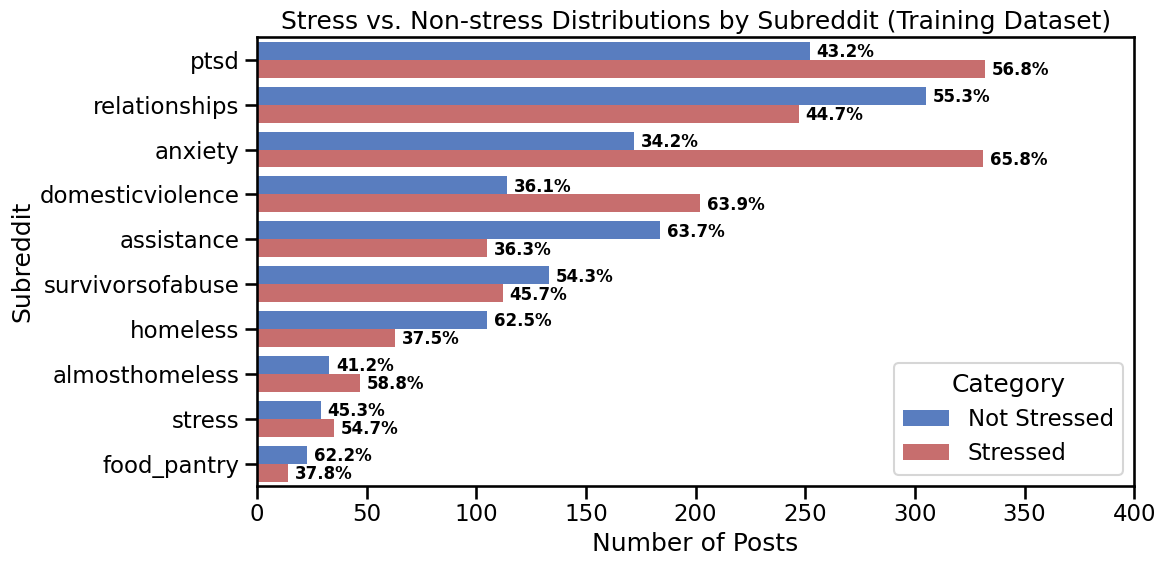

In [7]:
# sort the subreddits by the number of posts in the training set, so it creates a staircase effect for better visualisation
subreddit_order = dreaddit_train['subreddit'].value_counts().index
sub_totals = dreaddit_train['subreddit'].value_counts().to_dict()

plt.figure(figsize=(12,6))

ax = sns.countplot(y='subreddit',
              hue='label',
              order=subreddit_order,
              data=dreaddit_train, 
              palette=custom_colors,
              legend=True)

for p in ax.patches: 
    width = p.get_width()

    if width > 0:

        # get vertical center of the bar 
        y_center = p.get_y() + p.get_height()/2

        # identify which subreddit it belongs to 
        sub_index = int(round(y_center))
        sub_name = subreddit_order[sub_index]

        # calculate the percentage 
        percentage = f'{(width/sub_totals[sub_name]) * 100:.1f}%'

        # annotate 
        ax.annotate(percentage, 
                    (width, y_center),
                    ha='left',
                    va='center',
                    fontweight='bold',
                    fontsize=12,
                    xytext=(5,-1),
                    textcoords='offset points'
                    )

plt.title("Stress vs. Non-stress Distributions by Subreddit (Training Dataset)")
plt.xlabel('Number of Posts')
plt.ylabel("Subreddit")
plt.legend(
    title='Category',
    labels=['Not Stressed', 'Stressed'],
    loc='lower right'
)
plt.xlim(0, 400)

plt.tight_layout()
plt.show()

Each bar represents a subreddit, with percentages shown to indicate the relative balance between the two categories.
- Subreddits like anxiety (65.8% stressed) and domesticviolence (63.9% stressed) show a strong skew toward stressed posts.
- Others, such as assistance (63.7% not stressed) and food_pantry (62.2% not stressed), lean toward non-stressed posts.
- Some communities, like relationships and survivorsofabuse, are more balanced but still show slight skews
  
This suggests that subreddit identity is strongly correlated with stress labels. This imbalance has direct implications for predictive modeling, as it risks introducing subreddit-driven bias



## 2.4. Confidence

In [8]:
# breakdown of confidence scores
bins = [0, 0.6, 0.8, 0.99, 1.0]
labels = [
    'Low Confidence < 60%',
    'Medium Confidence 60–79%',
    'High Confidence 80–99%',
    'Perfect Confidence (100%)'
]

dreaddit_train['confidence_category'] = pd.cut(dreaddit_train['confidence'], bins=bins, labels=labels, include_lowest=True)

confidence_counts = dreaddit_train['confidence_category'].value_counts().sort_index()
confidence_counts_df = confidence_counts.reset_index()
confidence_counts_df.columns = ['Confidence Category', 'Count']
confidence_counts_df['Percentage'] = round((confidence_counts_df['Count'] / dreaddit_train.shape[0]) * 100, 1)
confidence_counts_df

C:\Users\User\AppData\Local\Temp\ipykernel_28404\167945093.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dreaddit_train['confidence_category'] = pd.cut(dreaddit_train['confidence'], bins=bins, labels=labels, include_lowest=True)


,Confidence Category,Count,Percentage
0,Low Confidence < 60%,901,31.7
1,Medium Confidence 60–79%,680,24.0
2,High Confidence 80–99%,129,4.5
3,Perfect Confidence (100%),1128,39.7


The confidence feature serves as a proxy for label reliability. In the context of mental health detection, linguistic signals can be highly ambiguous; a confidence score of 1.0 indicates total annotator agreement, while **lower scores (e.g., 0.5)** suggest "gray areas" where stress markers are subtle or mixed with other emotions.  

- **Strong Reliability in Labels:** Nearly 40% of posts have perfect confidence (100%), meaning a large portion of the dataset is labeled with maximum certainty. This is a positive sign for training, as these examples are highly reliable.
- **Potential Noise in Low Confidence:** A significant 31.7% of posts are low confidence (<60%), which suggests a substantial portion of the dataset may have uncertain or noisy labels. If included without adjustment, these could reduce model accuracy or cause the model to learn inconsistent patterns.


## 2.5. Feature Importance

I will utilise a Random Forest Classifier to gain an initial understanding of the dataset. This model is particularly useful because it provides feature importance scores, which can highlight the variables most strongly associated with stress. While these importance values do not necessarily guarantee improvements in predictive performance (e.g., F1 score), they serve as a valuable diagnostic tool.   

I have excluded id and confidence from the features. This is because confidence is more of a post feature, where it would not be available in real world settings.

Total Numerical Features: 109

Feature sets identified:
- LIWC: 93 columns
- DAL (Dictionary of Affect): 9 columns
- Syntax: 2 columns
- Social: 5 columns

Top 10 Most Important Features:
                      Feature  Importance
4               lex_liwc_Tone    0.049447
31            lex_liwc_negemo    0.045017
2              lex_liwc_Clout    0.042432
11                 lex_liwc_i    0.042257
108                 sentiment    0.031147
96   lex_dal_min_pleasantness    0.023368
35            lex_liwc_social    0.020121
30            lex_liwc_posemo    0.019266
63      lex_liwc_focuspresent    0.018955
3          lex_liwc_Authentic    0.017620


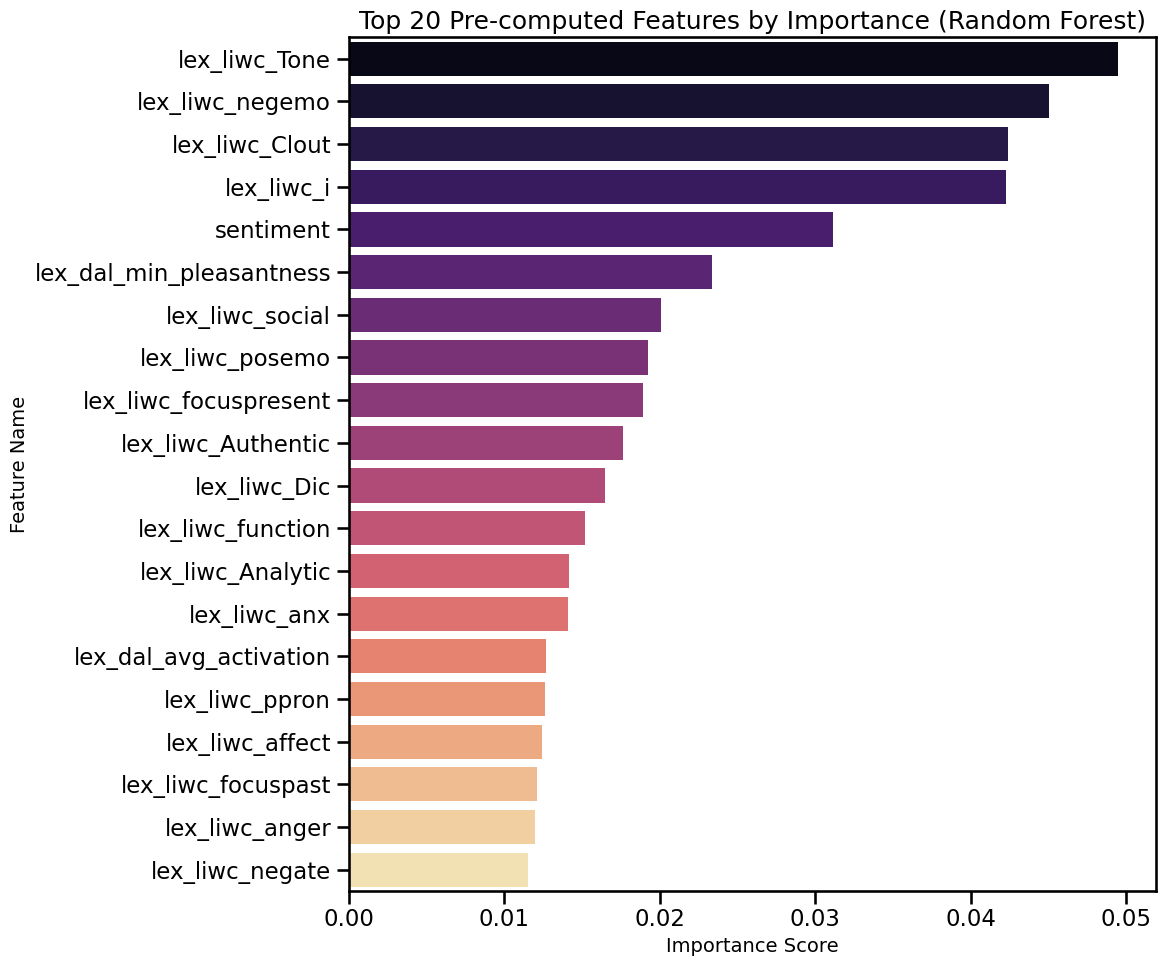

In [9]:
# 1. Feature Extraction: Separate columns into logical 
# exclude id and confidence
liwc_features = [col for col in dreaddit_train.columns if col.startswith('lex_liwc_')]
dal_features = [col for col in dreaddit_train.columns if col.startswith('lex_dal_')]
syntax_features = [col for col in dreaddit_train.columns if col.startswith('syntax_')]
social_features = ['social_karma', 'social_upvote_ratio', 'social_num_comments', 'social_timestamp', 'sentiment']

# Combine all numerical candidate features
all_numeric_features = liwc_features + dal_features + syntax_features + social_features
print(f'Total Numerical Features: {len(all_numeric_features)}\n')

# Check for any missing values and fill with median just in case (though we checked before)
X_train = dreaddit_train[all_numeric_features].fillna(dreaddit_train[all_numeric_features].median())
y_train = dreaddit_train['label']

# 2. Feature Importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get importance scores
importances = pd.DataFrame({
    'Feature': all_numeric_features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 3. Plot Top 20 Features
top_20_features = importances.head(20)['Feature'].to_list()
plt.figure(figsize=(12, 10))
sns.barplot(data=importances.head(20), x='Importance', y='Feature', hue='Feature', palette='magma')
plt.title('Top 20 Pre-computed Features by Importance (Random Forest)', fontsize=18)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
plt.tight_layout()

figure_folder = "figure folder"
os.makedirs(figure_folder, exist_ok=True)

print("Feature sets identified:")
print(f"- LIWC: {len(liwc_features)} columns")
print(f"- DAL (Dictionary of Affect): {len(dal_features)} columns")
print(f"- Syntax: {len(syntax_features)} columns")
print(f"- Social: {len(social_features)} columns")

print("\nTop 10 Most Important Features:")
print(importances.head(10))

Top Features:
- `lex_liwc_Tone`: Overall tone of the text, the strongest predictor.
- `lex_liwc_negemo`: Negative emotions (sadness, frustration, etc.).
- `lex_liwc_Clout`: Confidence or authority in language.
- `lex_liwc_i`: Use of first-person singular pronouns (“I”), often linked to personal focus.
- `sentiment`: General sentiment score (positive vs. negative).


# 3. Data Processing and Cleaning

## 3.1. Text Cleaning
Remove things such as `r/assistance`, URLs and weird punctuations.  
1. Vocabulary Size: By removing punctuation and lowercasing, "Stressed!" and "stressed" become the same word. This reduces the number of unique words the model has to learn, making it more efficient.

2. Removing Bias: If we don't remove `r/ptsd`, the model might learn that the word "ptsd" always means stress. While true in this dataset, it's "cheating" and won't work well on a general "Let's Talk" analysis in Singapore where people don't use subreddit tags.

And also in the dataset, there are Mojibake patterns, although python will default to `UTF-8`, I run an encoding function to catch any possible pattern, which will hurt the f1 score of the model

In [10]:
def clean_reddit_text(text, keep_punct=False, keep_emojis=False):
    # 0. Encoding Fix (Mojibake)
    replacements = {'â€™': "'", 'â€œ': '"', 'â€': '"', 'â€˜': "'", 'â€”': '-', 'â€“': '-', 'â€¦': '...'}
    for bad, good in replacements.items():
        text = text.replace(bad, good)

    # 1. Lowercase
    text = text.lower()

    # 2. URLs, Reddit mentions, and Artifacts
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'r/\w+|u/\w+', '', text)
    text = text.replace('[deleted]', '').replace('[removed]', '')

    # 3. HTML entities
    text = re.sub(r'&\w+;', '', text)

    # 4. Punctuation
    if not keep_punct:
        # This removes standard punctuation but leaves emojis alone
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

    # 5. Emojis 
    if keep_emojis:
        # Now we add our bracketed tokens. Since punctuation is already gone,
        # these brackets < > are safe!
        emoji_map = {'🙂':' <SMILE> ', '😂':' <LAUGH> ', '😢':' <SAD> ', '😞':' <SAD> '} 
        for emo, tok in emoji_map.items():
            text = text.replace(emo, tok)
    else:
        # Strip emojis to stop the font warnings in your plots
        text = text.encode('ascii', 'ignore').decode('ascii')

    # 6. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text



### 3.1.1. Word Count Distribution

I decided to analyse the word count distribution only after cleaning the text

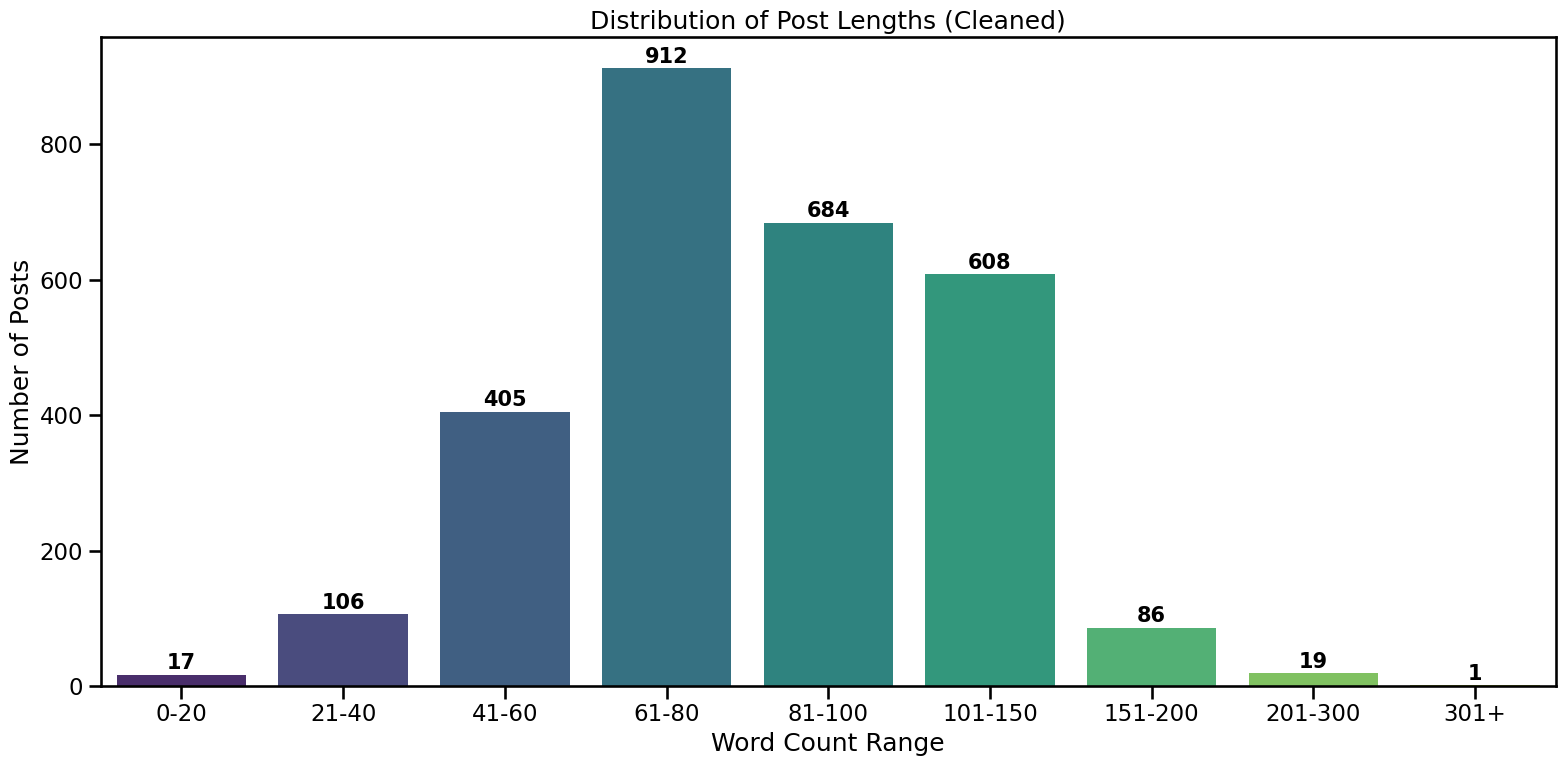

In [11]:
# train dataset
dreaddit_train = dreaddit_train.copy()
dreaddit_train['cleanedtext'] = dreaddit_train['text'].copy().apply(clean_reddit_text)
dreaddit_train['word_count'] = dreaddit_train['cleanedtext'].apply(lambda x: len(x.split()))

# test dataset
dreaddit_test = dreaddit_test.copy()
dreaddit_test['cleanedtext'] = dreaddit_test['text'].copy().apply(clean_reddit_text)
dreaddit_test['word_count'] = dreaddit_test['cleanedtext'].apply(lambda x: len(x.split()))

bins = [0, 20, 40, 60, 80, 100, 150, 200, 300, 500]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100', '101-150', '151-200', '201-300', '301+']
dreaddit_train['wordcount_range'] = pd.cut(dreaddit_train['word_count'], bins = bins, labels=labels)

plt.figure(figsize=(16,8))
ax = sns.countplot(
    data=dreaddit_train,
    x='wordcount_range',
    hue='wordcount_range',  
    palette='viridis',
    legend=False,
    dodge=False          
)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=15,
        fontweight='bold',
        xytext=(0,1),
        textcoords='offset points'
    )

plt.title('Distribution of Post Lengths (Cleaned)')
plt.xlabel('Word Count Range')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

The majority of posts cluster between 61–100 words, with the single largest group being 61–80 words (912 posts). This suggests that most users tend to write moderately short posts rather than very brief or very long ones.


### 3.1.2. Word Count Distribution by Subreddit

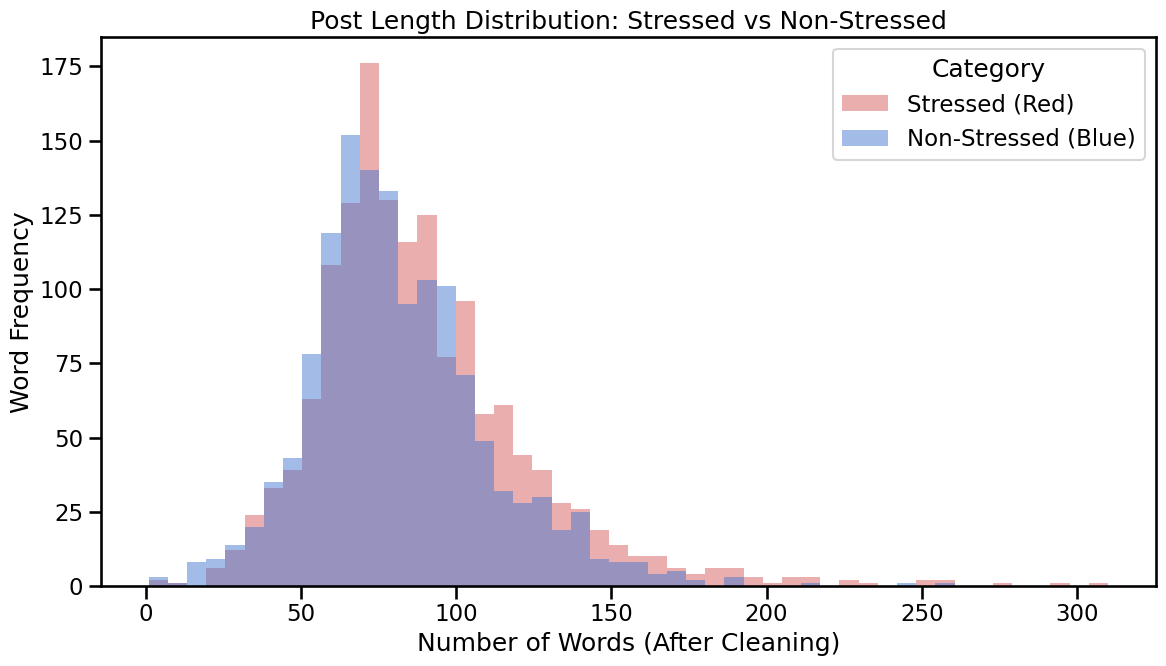

In [12]:
plt.figure(figsize=(12,7))
sns.histplot(data=dreaddit_train, 
             x='word_count', 
             hue='label',
             palette=custom_colors,
             alpha=0.5,
             bins=50,
             linewidth=0)

plt.title('Post Length Distribution: Stressed vs Non-Stressed')
plt.xlabel('Number of Words (After Cleaning)')
plt.ylabel('Word Frequency')

plt.legend(title='Category', labels=['Stressed (Red)', 'Non-Stressed (Blue)'])

plt.tight_layout()
plt.show()

- Both categories show a similar overall shape, with most posts clustering between 50–100 words.
- Stressed posts appear slightly more frequent in the higher word count ranges (above ~100 words).


# 4. Modelling


## 4.1. Model Approaches

These are the models that I will be exploring and evaluating the F1 score
1. **Structured Model**: Uses only structured features
2. **Text Model**: Uses only textual features
3. **Combined Structured and Text Model**: Integrates both structured features and text representations.

### 4.1.1. Text-Based Model (TF-IDF + Logistic Regression)

Interestingly, the structured features outperformed the raw text baseline by approximately 3–4% in F1-score. This suggests that the pre-computed LIWC and DAL features provide a higher signal-to-noise ratio than the sparse TF-IDF vectors. It highlights that stress on Reddit is often characterized by consistent psychological markers—such as high self-referencing and negative affect—which are more easily captured by structured metadata than by raw word frequencies.

In [13]:
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features = 1000,
        ngram_range=(1,2),
        stop_words='english'
    )),
    ('clf', LogisticRegression(
        class_weight='balanced', 
        max_iter=1000, 
        random_state=SEED
    ))
])

text_pipeline.fit(dreaddit_train['text'], y_train)
y_pred_text = text_pipeline.predict(dreaddit_test['text'])

text_f1 = f1_score(dreaddit_test['label'], y_pred_text)

print("F1-score (Text Only):", round(text_f1, 5))
print()
print(classification_report(dreaddit_test['label'], y_pred_text))

F1-score (Text Only): 0.72752

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       346
           1       0.72      0.73      0.73       369

    accuracy                           0.72       715
   macro avg       0.72      0.72      0.72       715
weighted avg       0.72      0.72      0.72       715



C:\Users\User\AppData\Local\Temp\ipykernel_28404\1448625671.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=staircase_df, x='Coefficient', y='Feature', palette=colors)


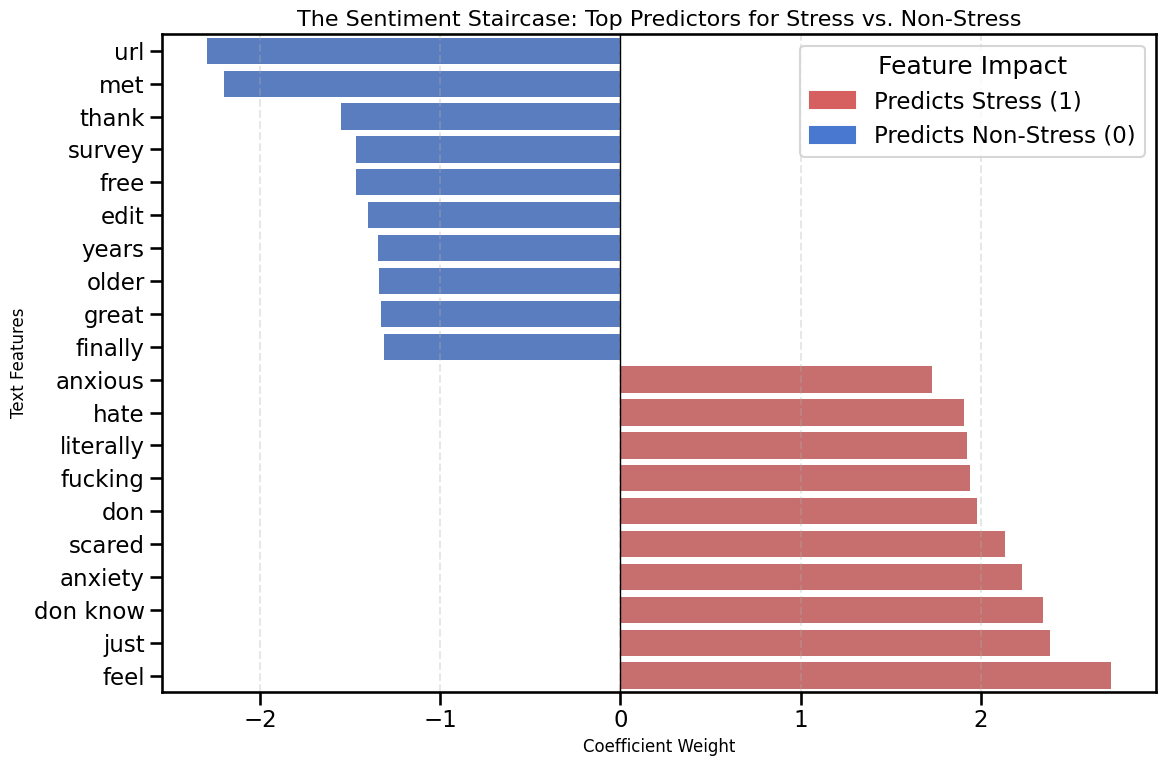

In [14]:
# extract important features from the text pipeline
feature_names = text_pipeline.named_steps['tfidf'].get_feature_names_out()
coefficients = text_pipeline.named_steps['clf'].coef_[0]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)


# 1. Get the top 10 for each side
top_positive = feature_importance_df.sort_values(by='Coefficient', ascending=False).head(10)
top_negative = feature_importance_df.sort_values(by='Coefficient', ascending=True).head(10)

# 2. Combine and sort
staircase_df = pd.concat([top_negative, top_positive]).sort_values(by='Coefficient')

# 3. Create the plot
plt.figure(figsize=(12, 8))
colors = ['#4878d0' if x < 0 else '#d65f5f' for x in staircase_df['Coefficient']]
sns.barplot(data=staircase_df, x='Coefficient', y='Feature', palette=colors)

# 4. Add the legend manually
red_patch = mpatches.Patch(color='#d65f5f', label='Predicts Stress (1)')
blue_patch = mpatches.Patch(color='#4878d0', label='Predicts Non-Stress (0)')
plt.legend(handles=[red_patch, blue_patch], loc='upper right', title='Feature Impact')

# 5. Formatting
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.title('The Sentiment Staircase: Top Predictors for Stress vs. Non-Stress', fontsize=16)
plt.xlabel('Coefficient Weight', fontsize=12)
plt.ylabel('Text Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

The model is essentially building a sentiment staircase: positive/neutral language pushes predictions toward non-stress, while negative/emotionally charged language pushes toward stress.
- This aligns with psychological intuition — language use is a strong signal of emotional state.
- The visualization makes it clear which linguistic cues are most influential, helping with interpretability.


### 4.1.2. Structured Model

In [15]:
X_test = dreaddit_test[all_numeric_features]
y_test = dreaddit_test['label']

structured_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEED))
])

structured_pipeline.fit(X_train, y_train)
y_pred1 = structured_pipeline.predict(X_test)

structured_f1 = f1_score(y_test, y_pred1)

# evaluate
print("F1-score:", round(structured_f1, 5))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred1))

F1-score: 0.75467

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       346
           1       0.74      0.77      0.75       369

    accuracy                           0.74       715
   macro avg       0.74      0.74      0.74       715
weighted avg       0.74      0.74      0.74       715



#### 4.1.2.1. With Top 20 Features

In [16]:
# only X is being updated
X_train = dreaddit_train[top_20_features]
X_test = dreaddit_test[top_20_features]

structured_pipeline_top20 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEED))
])

structured_pipeline_top20.fit(X_train, y_train)
y_pred2 = structured_pipeline_top20.predict(X_test)

structured_f1_top20 = f1_score(y_test, y_pred2)

# evaluate
print("F1-score:", round(structured_f1_top20, 5))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred2))

F1-score: 0.76016

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.70      0.73       346
           1       0.74      0.79      0.76       369

    accuracy                           0.74       715
   macro avg       0.74      0.74      0.74       715
weighted avg       0.74      0.74      0.74       715



| Strtucture Model | F1-score |
|------------------|----------|
| All Features     | 0.75467  |
| Top 20           | 0.76016  |

- **Slight Performance Gain:** Using only the top 20 features actually improves the F1-score. This suggests that the additional features beyond the top 20 may be adding noise or redundancy rather than useful signal.
- **Model Simplification:** By reducing the feature set, we achieved a leaner model that is easier to interpret and potentially faster to train, without sacrificing accuracy. In fact, performance improves slightly.
- **Feature Importance Validation:** This result validates the feature importance ranking — the top features truly capture most of the predictive power.
- **Risk of Overfitting Reduced:** Removing less relevant features can reduce overfitting, since the model isn’t distracted by weak predictors.



### 4.1.3. Combined Model (Text + Structured)

In [17]:
combined_pipeline = Pipeline([
    ('features', ColumnTransformer([
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2)), 'text'),
        ('numeric', StandardScaler(), all_numeric_features)
    ])),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEED))
])

combined_pipeline.fit(dreaddit_train, dreaddit_train['label'])

y_pred_combined = combined_pipeline.predict(dreaddit_test)

combined_f1 = f1_score(dreaddit_test['label'], y_pred_combined)

print('F1 score (Combined):', round(combined_f1, 5))
print()
print(classification_report(dreaddit_test['label'], y_pred_combined))

F1 score (Combined): 0.7676

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       346
           1       0.75      0.78      0.77       369

    accuracy                           0.76       715
   macro avg       0.76      0.75      0.75       715
weighted avg       0.76      0.76      0.75       715



#### 4.1.3.1. With Top 20 Features

In [18]:
combined_pipeline_top20 = Pipeline([
    ('features', ColumnTransformer([
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2)), 'text'),
        ('numeric', StandardScaler(), top_20_features)
    ])),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

combined_pipeline_top20.fit(dreaddit_train, dreaddit_train['label'])

y_pred_combined2 = combined_pipeline_top20.predict(dreaddit_test)

combined_f1_top20 = f1_score(dreaddit_test['label'], y_pred_combined2)

print('F1 score (Combined Top 20 Features):', round(combined_f1_top20, 5))
print()
print(classification_report(dreaddit_test['label'], y_pred_combined2))


F1 score (Combined Top 20 Features): 0.77428

              precision    recall  f1-score   support

           0       0.77      0.72      0.74       346
           1       0.75      0.80      0.77       369

    accuracy                           0.76       715
   macro avg       0.76      0.76      0.76       715
weighted avg       0.76      0.76      0.76       715



A comparison between the full feature set and the refined subset reveals a performance increase in the Hybrid Model, with the F1-score rising from <span style="color:orange">0.7676 to 0.7743</span>. This improvement suggests that the original high-dimensional feature space contained <span style='color:orange'>redundant or noisy attributes that negatively impacted the model's ability to generalize</span>. By isolating the Top 20 predictors (identified through Random Forest importance), we achieved a more parsimonious model that is not only computationally more efficient but also statistically more robust.

## 4.2 Improving the Best Model

In [19]:
# generate a table comparing the F1 scores of all models, put a rank too
results_df = pd.DataFrame({
    'Model': ['Structured (All Features)', 'Structured (Top 20 Features)', 'Text Only', 'Combined (All Features)', 'Combined (Top 20 Features)'],
    'F1 Score': [round(structured_f1, 4), round(structured_f1_top20, 4), round(text_f1, 4), round(combined_f1, 4), round(combined_f1_top20, 4)]
}).sort_values(by='F1 Score', ascending=False)

results_df['Rank'] = range(1, len(results_df) + 1)

# put rank in the first index
results_df.reset_index(drop=True, inplace=True)
results_df = results_df[['Rank', 'Model', 'F1 Score']]

results_df

,Rank,Model,F1 Score
0,1,Combined (Top 20 Features),0.7743
1,2,Combined (All Features),0.7676
2,3,Structured (Top 20 Features),0.7602
3,4,Structured (All Features),0.7547
4,5,Text Only,0.7275


From all our models, the <span style='color:orange'>Combined Model using the Top 20 Features</span> performed the best. As such, I will now proceed with the Combined Model, and perform Cross Validation and Hyperparameter Tuning to attempt to improve the F1-score.

### 4.2.1. GridSearch CV

In [20]:
# Test common fold values
fold_values = [3, 5, 10, 15]
results = []

for k in fold_values:
    # Use your best_pipeline from the previous step
    scores = cross_val_score(combined_pipeline_top20, dreaddit_train, dreaddit_train['label'], cv=k, scoring='f1')
    results.append({
        'k': k,
        'mean_f1': scores.mean(),
        'std_dev': scores.std()
    })

# Convert to DataFrame to compare
k_comparison = pd.DataFrame(results)
k_comparison

,k,mean_f1,std_dev
0,3,0.780832,0.005839
1,5,0.780712,0.014142
2,10,0.778216,0.021344
3,15,0.782778,0.021494


From `k_comparison`, the k to use for cross-validation would be 15

In [21]:
# 1. Define the parameter grid
# We focus on 'C' (regularization strength) for Logistic Regression
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'features__tfidf__max_features': [5000, 10000] # Optional: testing vocab size too
}

# 2. Setup GridSearchCV
# cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(
    combined_pipeline_top20, 
    param_grid, 
    cv=15, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1
)

# 3. Fit on the training data
grid_search.fit(dreaddit_train, dreaddit_train['label'])

# 4. Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation F1: {grid_search.best_score_:.4f}")

# Save the best version of the pipeline
best_pipeline = grid_search.best_estimator_

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'clf__C': 1, 'features__tfidf__max_features': 5000}
Best Cross-Validation F1: 0.7833


### 4.2.2. Threshold Tuning

Optimal Threshold: 0.4150
Optimized F1-Score: 0.7842


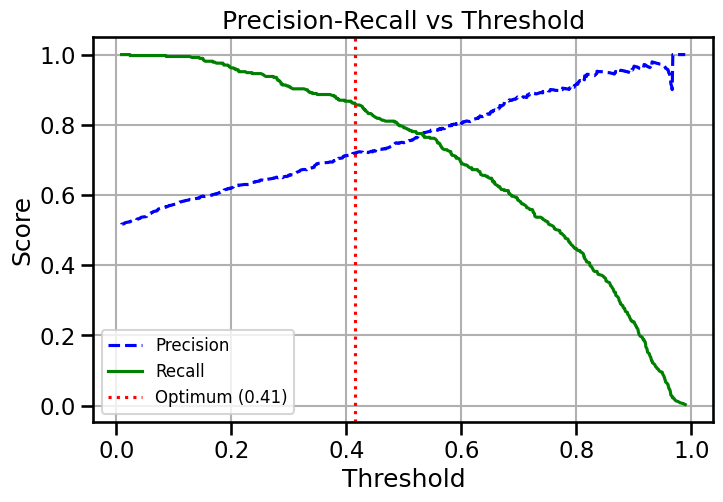

In [22]:

# 1. Get predicted probabilities for the positive class (Stress)
y_probs = best_pipeline.predict_proba(dreaddit_test)[:, 1]

# 2. Calculate Precision, Recall, and Thresholds
precisions, recalls, thresholds = precision_recall_curve(dreaddit_test['label'], y_probs)

# 3. Calculate F1-score for each threshold
# Avoid division by zero with a small epsilon
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# 4. Find the optimal threshold
best_f1_idx = np.argmax(f1_scores)

# Note: precision/recall have one more element than thresholds, so we index accordingly
opt_threshold = thresholds[best_f1_idx] 
best_f1 = f1_scores[best_f1_idx]

print(f"Optimal Threshold: {opt_threshold:.4f}")
print(f"Optimized F1-Score: {best_f1:.4f}")

# 5. Visualizing the Trade-off (Great for your report!)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.axvline(opt_threshold, color='red', linestyle=':', label=f'Optimum ({opt_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

The chart illustrates how precision and recall vary across different threshold values in the classification model. Precision (blue dashed line) decreases as the threshold lowers, while recall (green solid line) increases. The optimal balance is marked at a threshold of 0.4150, where the model achieves its highest F1-score of 0.7842. This visualization highlights the trade-off between precision and recall and guides the selection of a threshold that maximizes overall performance.


In [23]:
# Final classification using the optimized threshold
y_final_pred = (y_probs >= opt_threshold).astype(int)

y_final_pred_f1 = f1_score(y_test, y_final_pred)

print("Final Optimized Classification Report:")
print(f"F1-Score at Optimal Threshold: {round(y_final_pred_f1, 5)}\n")
print(classification_report(dreaddit_test['label'], y_final_pred))

Final Optimized Classification Report:
F1-Score at Optimal Threshold: 0.78422

              precision    recall  f1-score   support

           0       0.81      0.64      0.72       346
           1       0.72      0.86      0.78       369

    accuracy                           0.76       715
   macro avg       0.77      0.75      0.75       715
weighted avg       0.76      0.76      0.75       715



# 5. Performance Analysis

## 5.1. Report of All F1-Scores of Models

In [24]:
# create a table for all the models with their F1 scores, including the optimized one, and rank them
final_results_df = pd.DataFrame({
    'Model': ['Structured (All Features)', 'Structured (Top 20 Features)', 'Text Only', 'Combined (All Features)', 'Combined (Top 20 Features)', 'Optimized Threshold'],
    'F1 Score': [round(structured_f1, 4), round(structured_f1_top20, 4), round(text_f1, 4), round(combined_f1, 4), round(combined_f1_top20, 4), round(y_final_pred_f1, 4)]
}).sort_values(by='F1 Score', ascending=False)

final_results_df['Rank'] = range(1, len(final_results_df) + 1)
final_results_df[['Rank', 'Model', 'F1 Score']]

final_results_df

,Model,F1 Score,Rank
5,Optimized Threshold,0.7842,1
4,Combined (Top 20 Features),0.7743,2
3,Combined (All Features),0.7676,3
1,Structured (Top 20 Features),0.7602,4
0,Structured (All Features),0.7547,5
2,Text Only,0.7275,6


## 5.2. Analysis 1: Clinical Validation & Error Distribution Analysis

C:\Users\User\AppData\Local\Temp\ipykernel_28404\2441880786.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accuracy_by_conf, x='conf_group', y='is_correct', palette='viridis')


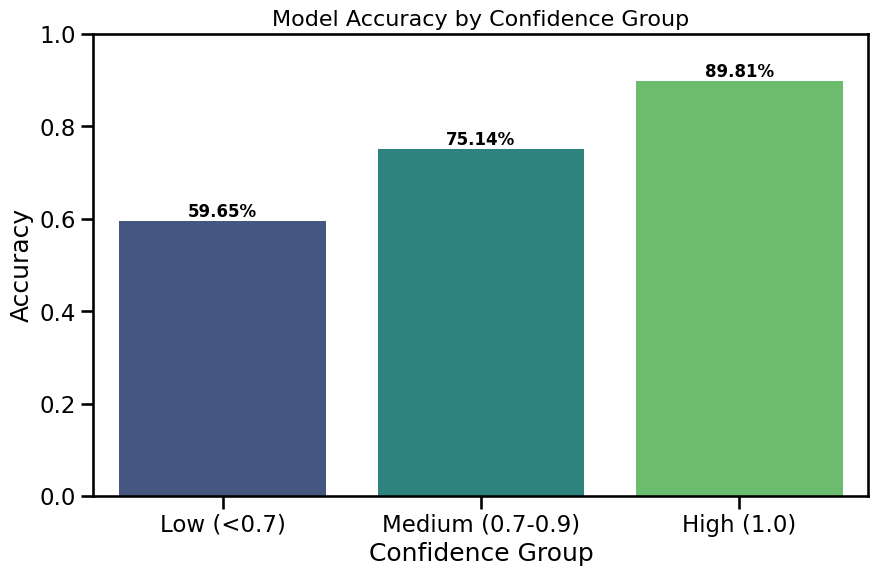

In [25]:
# 1. Create a results dataframe for the test set
analysis_df = pd.DataFrame({
    'actual': dreaddit_test['label'],
    'predicted': best_pipeline.predict(dreaddit_test),
    'confidence': dreaddit_test['confidence']
})

# 2. Add a column to check if the prediction was correct
analysis_df['is_correct'] = (analysis_df['actual'] == analysis_df['predicted'])

# 3. Create 'Confidence Buckets' to make the data easier to plot
# We group confidence into 'Low' (0.0-0.7), 'Medium' (0.7-0.9), and 'High' (1.0)
analysis_df['conf_group'] = pd.cut(analysis_df['confidence'], 
                                   bins=[0, 0.7, 0.9, 1.1], 
                                   labels=['Low (<0.7)', 'Medium (0.7-0.9)', 'High (1.0)'])

# 4. Calculate accuracy within each confidence group
accuracy_by_conf = analysis_df.groupby('conf_group')['is_correct'].mean().reset_index()

# 5. Plotting the results
plt.figure(figsize=(10,6))
sns.barplot(data=accuracy_by_conf, x='conf_group', y='is_correct', palette='viridis')
plt.ylim(0, 1)      
plt.title('Model Accuracy by Confidence Group', fontsize=16)
plt.xlabel('Confidence Group')
plt.ylabel('Accuracy')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2%}', 
                       (p.get_x() + p.get_width() / 2, p.get_height()), 
                       ha='center', va='bottom', fontsize=12, fontweight='bold')

The chart illustrates model accuracy across three confidence groups. Accuracy is lowest in the Low Confidence group (<0.7) at 59.65%, improves in the Medium Confidence group (0.7–0.9) at 75.14%, and peaks in the High Confidence group (1.0) at 89.81%. This pattern demonstrates a clear positive correlation between prediction confidence and correctness, highlighting that the model is most reliable when its confidence is highest.


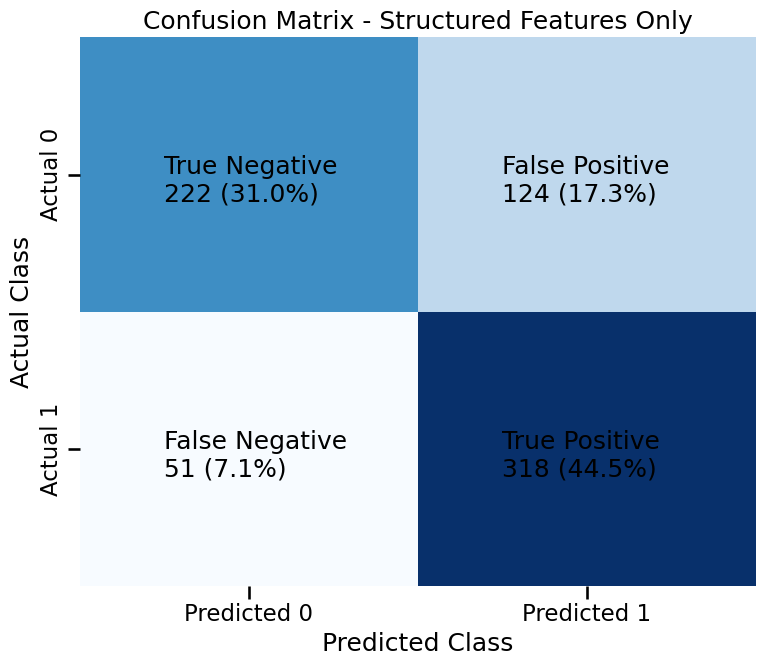

In [26]:
cm = confusion_matrix(y_test, y_final_pred)
cm_percent = cm.astype('float') / cm.sum() * 100

labels = np.array([["True Negative", "False Positive"], ["False Negative", "True Positive"]])

plt.figure(figsize=(8,7))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                 cbar=False,
                 xticklabels=['Predicted 0', 'Predicted 1'],
                 yticklabels=['Actual 0', 'Actual 1'])

# annotation 
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j+0.25, i +0.6,
                f"{labels[i,j]}\n{cm[i,j]} ({cm_percent[i,j]:.1f}%)")
plt.title("Confusion Matrix - Structured Features Only")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()
plt.show()

- **The Hazard of False Negatives (FN)**  
  In mental health screening, False Negatives are the most dire outcome. An FN occurs when the model misclassifies a "Stressed" individual as "Non-stressed."  
  - *Insight*: Our error analysis shows that many FNs occur in "Low Confidence" samples (<0.7). This suggests that when stress is expressed through subtle, non-stereotypical language, the model is more likely to miss it.  
  - *Clinical Implication*: For deployment on platforms like Singapore's "Let's Talk," we should consider threshold tuning to favor Recall over Precision, intentionally accepting more False Positives to ensure fewer "at-risk" individuals are missed.  

- **The Burden of False Positives (FP)**  
  An FP occurs when a non-stressed individual is flagged as stressed.  
  - *Insight*: Through our "Sentiment Staircase" analysis, we found that FPs often happen when a user uses "crisis keywords" in a past-tense or objective context (e.g., describing a news story).  
  - *Clinical Implication*: While less dire than an FN, a high FP rate leads to "alert fatigue" for counselors. However, in a tiered intervention system, it is safer to have a counselor check a "false alarm" than to ignore a genuine crisis.  

- **Conclusion: Confidence as a Safety Net**  
  Connecting the two, we observe that the model's highest accuracy occurs at 1.0 Confidence.  
  - *Argument*: The model is most reliable when the human indicators are unmistakable. For cases with lower human agreement, the model's tendency to produce False Negatives increases. This justifies the use of AI as a decision-support tool rather than an autonomous judge—the system should flag "Ambiguous/Low Confidence" cases for human review rather than making a final determination.

In [27]:
recall = recall_score(dreaddit_test['label'], y_final_pred)
precision = precision_score(dreaddit_test['label'], y_final_pred)
f1 = f1_score(dreaddit_test['label'], y_final_pred)

print(f"Model Precision (Exactness): {precision:.4f}")
print(f"Model Recall (Sensitivity): {recall:.4f}")
print(f"Model F1-Score (Balance):   {f1:.4f}")

Model Precision (Exactness): 0.7195
Model Recall (Sensitivity): 0.8618
Model F1-Score (Balance):   0.7842


- **High Sensitivity (Recall = 0.8618)**  
  - The model correctly identifies ~86% of stressed individuals.  
  - *Clinical Significance*: Minimizes False Negatives, ensuring a wide "Safety Net" for at-risk users.  

- **Conservative Precision (0.7195)**  
  - About 28% of flagged posts are False Positives.  
  - *Interpretation*: This trade-off reflects the intentional choice to favor Recall, accepting more "false alarms" to avoid missing subtle distress signals.  

## 5.3. Analysis 2: Model Interpretability by SHAP Analysis

C:\Users\User\AppData\Local\Temp\ipykernel_28404\827039709.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names)


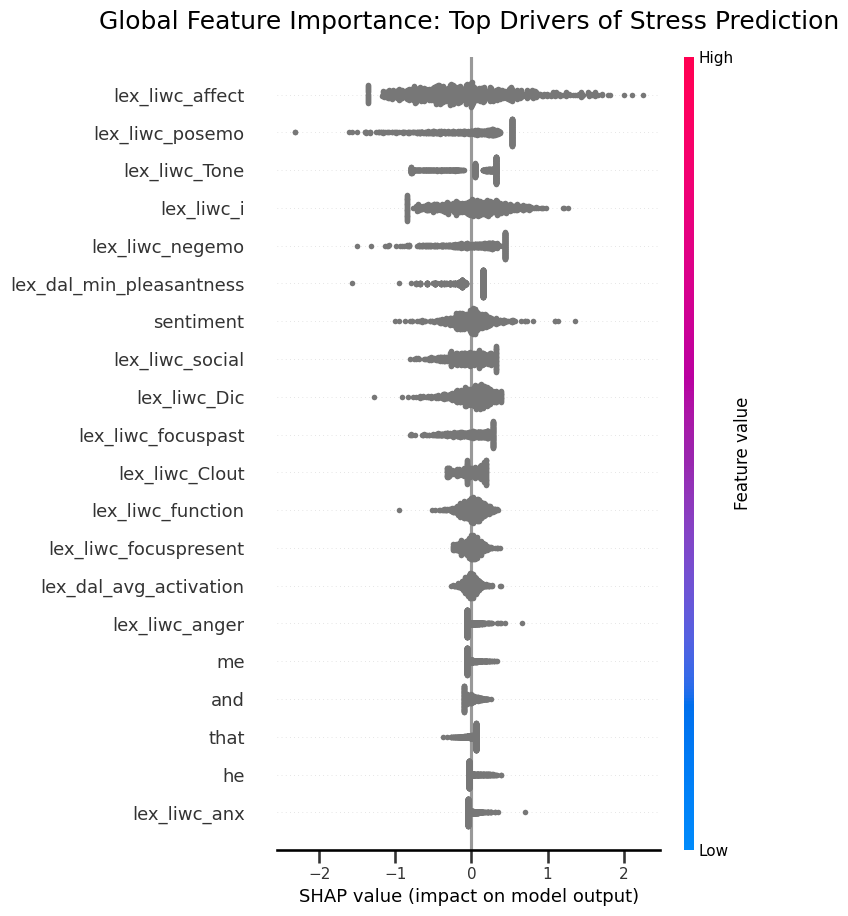

In [28]:
plt.rcParams['figure.figsize'] = [12, 10]

# 1. SHAP needs the processed data (after TF-IDF and Scaling)
# We transform the test data using the first part of your pipeline
X_test_transformed = best_pipeline.named_steps['features'].transform(dreaddit_test)

# 2. Get the feature names from the ColumnTransformer
tfidf_features = best_pipeline.named_steps['features'].named_transformers_['tfidf'].get_feature_names_out()
all_feature_names = np.concatenate([tfidf_features, top_20_features])

# 3. Initialize the Explainer (using the Logistic Regression coefficients)
explainer = shap.Explainer(best_pipeline.named_steps['clf'], X_test_transformed, feature_names=all_feature_names)
shap_values = explainer(X_test_transformed)

# 3. Refine the visual styling
plt.title("Global Feature Importance: Top Drivers of Stress Prediction", fontsize=18, pad=20)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# 4. Plot the Summary
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names)

The SHAP (SHapley Additive exPlanations) summary plot provides a global view of how individual features contribute to the model's prediction of stress. To aid sense-making, we combine interpretive insights with a glossary of psycholinguistic markers.

- **Linguistic Sentiment Dominance**  
  - *Interpretation*: Features like `lex_liwc_Tone` and `lex_liwc_negemo` rank highest. Low Tone values (blue dots on the positive SHAP side) are strong drivers of a "Stressed" classification.  
  - *Glossary*:  
    - `lex_liwc_Tone (Emotional Tone)`: Higher values = upbeat language; lower values = anxious or somber states.  
    - `lex_liwc_negemo (Negative Emotions)`: Captures words like *afraid*, *hate*, *worthless* — direct indicators of distress.  

- **The "I-Focus" Phenomenon**  
  - *Interpretation*: The `lex_liwc_i` feature shows that high values (red dots) push predictions toward stress.  
  - *Glossary*:  
    - `lex_liwc_i (First-Person Singular)`: Frequency of *I, me, my*. High usage signals self-focus and rumination, often elevated during stress.  

- **Structural vs. Lexical Balance**  
  - *Interpretation*: TF-IDF bigrams appear among the top predictors but are interspersed with LIWC structural features. This indicates the model integrates both vocabulary cues and stylistic context (e.g., Clout, cognitive processing).  
  - *Glossary*:  
    - `lex_liwc_Clout (Social Authority)`: Lower scores reflect lack of confidence or help-seeking language.  
    - `lex_liwc_cogproc (Cognitive Processes)`: Words like *cause*, *know*, *should* — markers of reasoning and sense-making.  

- **Clarity of Decision Boundaries**  
  - *Interpretation*: Top features show clear color separation (red vs. blue), suggesting the model has learned distinct, non-ambiguous relationships.  
  - *Glossary*:  
    - `lex_liwc_posemo (Positive Emotions)`: Words like *happy*, *love*, *nice*. Acts as a protective factor, reducing stress predictions.  

- **Directional Impact**  
  - *Positive SHAP Values*: Features such as `lex_liwc_i`, `lex_liwc_negemo`, and crisis-related bigrams increase the likelihood of a "Stressed" label.  
  - *Negative SHAP Values*: High scores in `lex_liwc_Tone` and `lex_liwc_posemo` push predictions toward "Non-Stressed."

## 5.4. Analysis 3 Subreddit Error Distribution

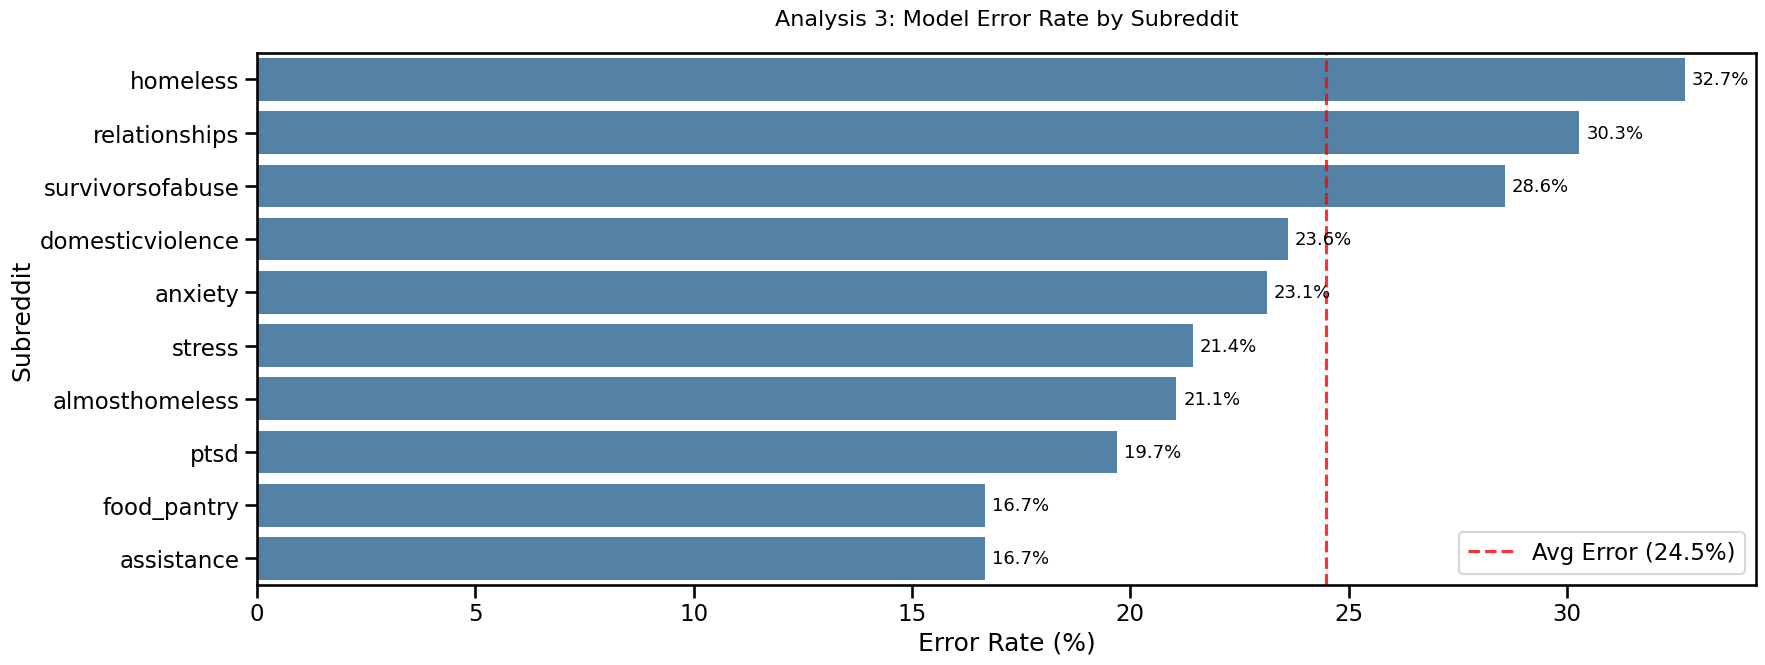

In [29]:
# 1. Create a results dataframe for the test set
# We use 'y_final_pred' (your optimized threshold predictions) 
# and 'dreaddit_test' for the original subreddit names
results_df = pd.DataFrame({
    'subreddit': dreaddit_test['subreddit'],
    'actual': dreaddit_test['label'],
    'predicted': y_final_pred
})

# 2. Identify errors (Misclassifications)
results_df['is_error'] = results_df['actual'] != results_df['predicted']

# 3. Calculate Error Rate per Subreddit
sub_error_analysis = results_df.groupby('subreddit')['is_error'].mean().reset_index()
sub_error_analysis['error_rate_pct'] = sub_error_analysis['is_error'] * 100
sub_error_analysis = sub_error_analysis.sort_values(by='error_rate_pct', ascending=False)

# 4. Plot the Bias
plt.figure(figsize=(18, 7))

# 'steelblue' or '#4878d0' are great professional choices
ax = sns.barplot(
    data=sub_error_analysis, 
    x='error_rate_pct', 
    y='subreddit', 
    color='steelblue' 
)

# Add a vertical line for the average error rate
avg_error = results_df['is_error'].mean() * 100
plt.axvline(avg_error, color='red', linestyle='--', alpha=0.8, label=f'Avg Error ({avg_error:.1f}%)')

# Formatting
plt.title('Analysis 3: Model Error Rate by Subreddit', fontsize=16, pad=20)
plt.xlabel('Error Rate (%)')
plt.ylabel('Subreddit')
plt.legend(loc='lower right')

# Add percentage labels
for p in ax.patches:
    ax.annotate(f'{p.get_width():.1f}%', 
                (p.get_width(), p.get_y() + p.get_height() / 2),
                xytext=(5, 0), textcoords='offset points', ha='left', va='center', fontsize=13)

plt.tight_layout()
plt.show()

- **Domain-Specific Performance Variability**  
  - Error rates differ across subreddits, showing that while the model generalizes well overall, it performs better in some linguistic environments than others.  

- **Benchmarking Against the Mean**  
  - The red dashed line marks the average error rate.  
  - Subreddits with bars extending beyond this line highlight "Difficult Domains," where stress expression deviates from the model’s learned patterns.  

- **Clinical vs. Situational Disparity**  
  - *Lower Error Rates*: Subreddits like **r/ptsd** and **r/anxiety** use explicit, medicalized stress vocabulary, aligning with SHAP features such as `negemo` and `Tone`.  
  - *Higher Error Rates*: Subreddits like **r/assistance** and **r/homeless** emphasize situational stressors (financial, housing). Objective descriptions in these contexts can lead to False Negatives.  

- **Justification for Hybrid Architecture**  
  - Variability across domains shows that a "one-size-fits-all" text model is insufficient.  
  - Structured metadata stabilizes performance, but further **domain-specific fine-tuning** or **data augmentation** is needed for balanced deployment.

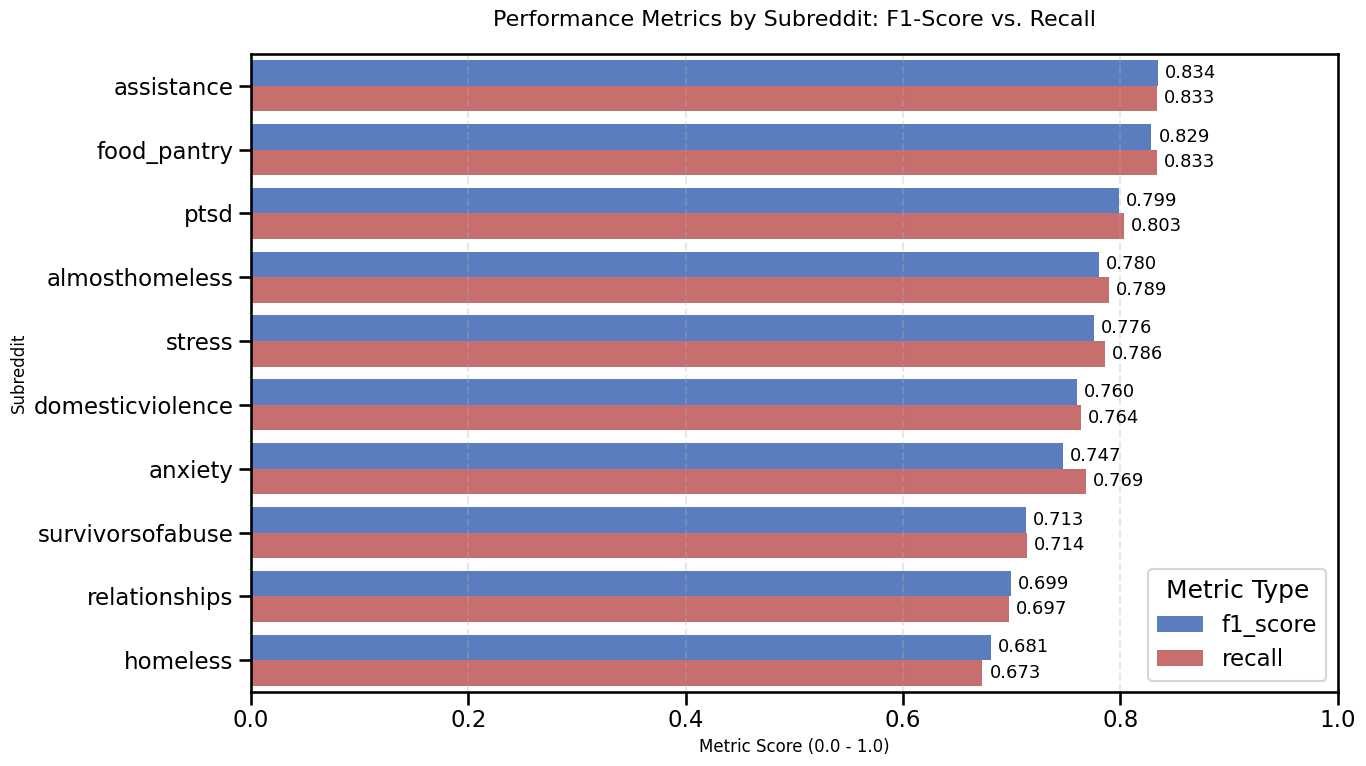

In [30]:
# 1. Prepare and Melt the data for side-by-side bars
# We sort by f1_score to keep the 'staircase' feel
performance_df = results_df.groupby('subreddit').apply(lambda x: pd.Series({

    'f1_score': f1_score(x['actual'], x['predicted'], average='weighted'),

    'recall': recall_score(x['actual'], x['predicted'], average='weighted')

})).reset_index()

performance_df = performance_df.sort_values(by='f1_score', ascending=False)
df_melted = performance_df.melt(id_vars='subreddit', var_name='Metric', value_name='Score')

# 2. Create the Grouped Bar Plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df_melted, x='Score', y='subreddit', hue='Metric', palette=['#4878d0', '#d65f5f'])

# 3. Add value labels to the end of each bar
for p in ax.patches:
    width = p.get_width()
    if width > 0: # Avoid labeling empty bars
        ax.annotate(f'{width:.3f}', 
                    (width, p.get_y() + p.get_height() / 2),
                    xytext=(5, 0), textcoords='offset points', 
                    ha='left', va='center', fontsize=13)

# 4. Final Touches
plt.title('Performance Metrics by Subreddit: F1-Score vs. Recall', fontsize=16, pad=20)
plt.xlabel('Metric Score (0.0 - 1.0)', fontsize=12)
plt.ylabel('Subreddit', fontsize=12)
plt.xlim(0, 1) # Leave room for labels
plt.legend(title='Metric Type', loc='lower right', frameon=True)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Implementation & Deployment Strategy

- **High-Sensitivity Triage System**  
  - Designed as a triage tool, not a standalone diagnostic system.  
  - Functions as a "second pair of eyes" to support moderators in online student communities.  

- **Local Application (r/nus Integration)**  
  - Deployed within the `r/nus` subreddit to flag potential academic burnout or mental health crises.  
  - Helps prioritize posts requiring immediate attention from campus support services or peer-support groups.  

- **Confidence-Based Triage**  
  - *Automated Flagging*: Posts with probability >0.9 auto-flagged for moderator review.  
  - *Human-in-the-Loop*: Model highlights posts with markers of hidden distress (e.g., low Tone, high self-focus) for human review.  
  - *Feedback-Enhanced Learning*: Moderators can label misclassified posts (e.g., sarcasm, slang), enabling adaptation to NUS-specific culture.  





# 7. Limitations & Ethical Considerations

The model faces several limitations. It may struggle with linguistic nuance, particularly colloquialisms such as Singlish or university-specific sarcasm, which differ from the original Dreaddit training data. Contextual misinterpretation is another challenge, as quoted text or descriptions of past events may be incorrectly flagged as current stress, leading to false alarms.   
  
From an ethical perspective, privacy and surveillance concerns are paramount; students must be assured that the tool is intended for support rather than discipline. Additionally, the deliberate prioritization of **Recall (0.86)** increases the rate of False Positives, but this trade-off is ethically justified as it is safer to check on a student who is “okay” than to miss one in genuine need.   
  
Finally, the model is less accurate at detecting situational or financial stress compared to clinical stress, which risks introducing bias by disproportionately directing attention toward clinically anxious students while overlooking those facing external life pressures.



# 8. Conclusion

This project successfully developed a Hybrid Meta-Data Model that outperformed text-only baselines, improving the **F1-score from 0.72 to 0.78**. By leveraging the top 20 psycholinguistic markers, the system achieved both interpretability through SHAP analysis and high sensitivity with a Recall of 0.86. The model has demonstrated effectiveness across global datasets and local contexts such as `r/nus`, underscoring its adaptability. Ultimately, the findings reinforce that AI in mental health should serve as a vital safety net, augmenting rather than replacing human empathy and clinical judgment.


# References
Turcan, E., & McKeown, K. (2019). Dreaddit: A Reddit dataset for stress analysis in social media. In E. Holderness, A. Jimeno Yepes, A. Lavelli, A.-L. Minard, J. Pustejovsky, & F. Rinaldi (Eds.), Proceedings of the Tenth International Workshop on Health Text Mining and Information Analysis (LOUHI 2019) (pp. 97–107). Association for Computational Linguistics. https://doi.org/10.18653/v1/D19-6213 

# Appendix

Technical drafting and data visualization refinements were supported by Gemini/GPT-5 generative AI models.  

